<br />
<div style="text-align: center;">
    <span style="font-weight: bold; color:#6dc; font-family: 'Arial Narrow'; font-size: 2.5em;">Monthly Air Temperature Anomalies (NOAA)</span>
</div>
<br />

<br />
<span style="color:#444; font-family: 'Arial'; font-size: 1.3em;">NOAA Global Surface Temperature (NOAAGlobalTemp).
Data taken from: https://www.esrl.noaa.gov/psd/data/gridded/data.noaaglobaltemp.html </span>
<br />

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import urllib2
from contextlib import closing
from matplotlib.pyplot import cm
import matplotlib.image as mpimg
import rasterio
import os
import shutil
import netCDF4
%matplotlib inline

/Users/vizzuality/anaconda/lib/python2.7/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
remote_path = 'ftp://ftp.cdc.noaa.gov/Datasets/noaaglobaltemp/'
last_file = 'air.mon.anom.nc'
local_path = os.getcwd()

print (remote_path)
print (last_file)
print (local_path)

ftp://ftp.cdc.noaa.gov/Datasets/noaaglobaltemp/
air.mon.anom.nc
/Users/vizzuality/Documents/Vizzuality/RW/planet_pulse/Notebooks


In [3]:
with closing(urllib2.urlopen(remote_path+last_file)) as r:
    with open(last_file, 'wb') as f:
        shutil.copyfileobj(r, f)

In [4]:
ncfile = xr.open_dataset(local_path+'/'+last_file, decode_times=False)

In [5]:
#To see availables variables in the file
print('* Variables disponibles en el fichero:')
for v in ncfile.variables:
    print(v)

* Variables disponibles en el fichero:
lat
lon
time
time_bnds
air


In [6]:
#To see general info of the .nc file 
ncfile.info()

xarray.Dataset {
dimensions:
	lat = 36 ;
	lon = 72 ;
	nbnds = 2 ;
	time = 1648 ;

variables:
	float32 lat(lat) ;
		lat:long_name = Latitude ;
		lat:units = degrees_north ;
		lat:actual_range = [-87.5  87.5] ;
		lat:axis = Y ;
		lat:coordinate_defines = point ;
		lat:standard_name = latitude ;
	float32 lon(lon) ;
		lon:long_name = Longitude ;
		lon:units = degrees_east ;
		lon:actual_range = [   2.5  357.5] ;
		lon:axis = X ;
		lon:coordinate_defines = point ;
		lon:standard_name = longitude ;
	float64 time(time) ;
		time:units = days since 1800-1-1 00:00:0.0 ;
		time:long_name = Time ;
		time:delta_t = 0000-01-00 00:00:00 ;
		time:avg_period = 0000-01-00 00:00:00 ;
		time:standard_name = time ;
		time:axis = T ;
		time:coordinate_defines = start ;
		time:bounds = time_bnds ;
		time:actual_range = [ 29219.  79348.] ;
	float64 time_bnds(time, nbnds) ;
		time_bnds:long_name = Time Boundaries ;
	float64 air(time, lat, lon) ;
		air:var_desc = Air Temperature ;
		air:level_desc = Surface ;
	

<br />
<span style="color:#444; font-family: 'Arial'; font-size: 1.3em;">So, we want to see our data of interest:</span>
<br />

[u'lat', u'lon', u'time', u'time_bnds', u'air']
<type 'netCDF4._netCDF4.Variable'>
float32 air(time, lat, lon)
    var_desc: Air Temperature
    level_desc: Surface
    statistic: Anomaly
    parent_stat: Observation
    valid_range: [-40.  40.]
    units: degC
    missing_value: -9.96921e+36
    long_name: Surface Air Temperature and SST Monthly Anomaly
    precision: 2
    cell_methods: time: anomaly (monthly from values)
    standard_name: air_temperature_anomaly
    dataset: NOAA Global Temperature
    actual_range: [-20.09659958  16.69619942]
    date_of_file_acquired: 2017-6-12
unlimited dimensions: time
current shape = (1648, 36, 72)
filling on, default _FillValue of 9.96920996839e+36 used



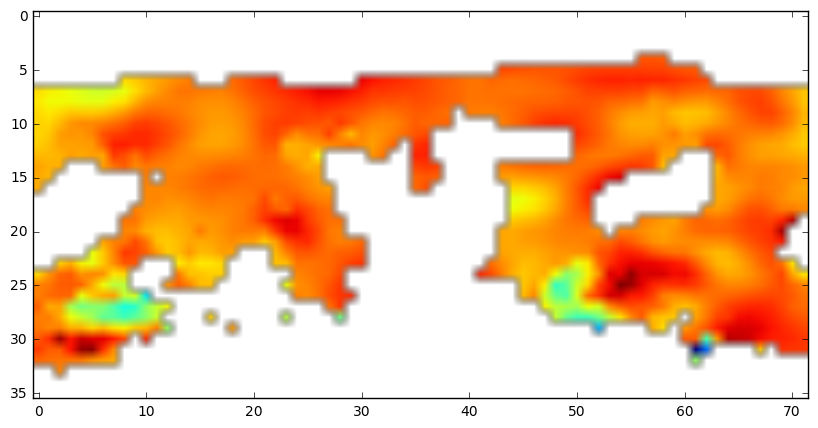

In [7]:
# open a local NetCDF file
url = local_path+'/'+last_file
nc = netCDF4.Dataset(url)

# examine once again to be sure the variables
print nc.variables.keys()
print nc.variables['air']

# Taking the data
topo = nc.variables['air'][1,:,:]

# Ploting
plt.figure(figsize=(10,10))
plt.imshow(topo)


<br />
<span style="font-weight: bold; color:#6dc; font-family: 'Arial Narrow'; font-size: 2.5em;">GitHub Script</span>
<br />

In [8]:
import numpy as np
import os
import urllib2
import shutil
from contextlib import closing
from netCDF4 import Dataset
import rasterio
import tinys3
np.set_printoptions(threshold='nan')

In [9]:
def dataDownload(): 
    remote_path = 'ftp://ftp.cdc.noaa.gov/Datasets/noaaglobaltemp/'
    last_file = 'air.mon.anom.nc'

    local_path = os.getcwd()

    print (remote_path)
    print (last_file)
    print (local_path)

    #Download the file .nc
    with closing(urllib2.urlopen(remote_path+last_file)) as r:
        with open(last_file, 'wb') as f:
            shutil.copyfileobj(r, f)

    ncfile = Dataset(local_path+'/'+last_file)
    
    return last_file

In [10]:
def netcdf2tif(dst,outFile):
    nc = Dataset(dst)
    data = nc['air'][1,:,:]
            
    data[data < -40] = -99
    data[data > 40] = -99
    print data
    
    # Return lat info
    south_lat = -88.75
    north_lat = 88.75

    # Return lon info
    west_lon = -177.5
    east_lon = 177.5
    # Transformation function
    transform = rasterio.transform.from_bounds(west_lon, south_lat, east_lon, north_lat, data.shape[1], data.shape[0])
    # Profile
    profile = {
        'driver':'GTiff', 
        'height':data.shape[0], 
        'width':data.shape[1], 
        'count':1, 
        'dtype':np.float64, 
        'crs':'EPSG:4326', 
        'transform':transform, 
        'compress':'lzw', 
        'nodata':-99
    }
    with rasterio.open(outFile, 'w', **profile) as dst:
        dst.write(data.astype(profile['dtype']), 1)

In [11]:
def s3Upload(outFile):
    # Push to Amazon S3 instance
    conn = tinys3.Connection(os.getenv('S3_ACCESS_KEY'),os.getenv('S3_SECRET_KEY'),tls=True)
    f = open(outFile,'rb')
    conn.upload(outFile,f,os.getenv('BUCKET'))

In [12]:
# Execution
outFile ='air_temo_anomalies.tif'
print 'starting'
file = dataDownload()
print 'downloaded'
netcdf2tif(file,outFile)
print 'converted'
#s3Upload(outFile)
print 'finish'

starting
ftp://ftp.cdc.noaa.gov/Datasets/noaaglobaltemp/
air.mon.anom.nc
/Users/vizzuality/Documents/Vizzuality/RW/planet_pulse/Notebooks
downloaded
[[-99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0
  -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0
  -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0
  -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0
  -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0
  -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0]
 [-99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0
  -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0
  -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0
  -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0
  -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0 -99.0
  -99.0 -99.0 -99.0 -99.0 -99.0 -99.

<br />
<span style="font-weight: bold; color:#6dc; font-family: 'Arial Narrow'; font-size: 2.5em;">Other availables datasets</span>
<br />

<br />
<span style="font-weight: bold; color:#444; font-family: 'Arial Narrow'; font-size: 2em;">Jones (CRU) Air Temperature Anomalies Version 4: CRUTEM4</span>
<br />
<span style="font-weight: bold; color:#444; font-family: 'Arial Narrow'; font-size: 2em;">https://www.esrl.noaa.gov/psd/data/gridded/data.crutem4.html</span>

ftp://ftp.cdc.noaa.gov/Datasets/cru/crutem4/std/
air.mon.anom.nc
/Users/vizzuality/Documents/Vizzuality/RW/planet_pulse/Notebooks
[u'lat', u'lon', u'time', u'time_bnds', u'air']
<type 'netCDF4._netCDF4.Variable'>
float32 air(time, lat, lon)
    dataset: CRUTEM4
    var_desc: Air Temperature
    level_desc: Surface
    statistic: Anomaly
    parent_stat: Observation
    valid_range: [-40.  40.]
    actual_range: [-21.29999924  20.5       ]
    units: degC
    missing_value: -9.96921e+36
    long_name: CRUTEM4: Surface Air Temperature Monthly Anomaly
    precision: 2
    cell_methods: time: anomaly (monthly from values)
    standard_name: air_temperature_anomaly
unlimited dimensions: time
current shape = (2008, 36, 72)
filling off



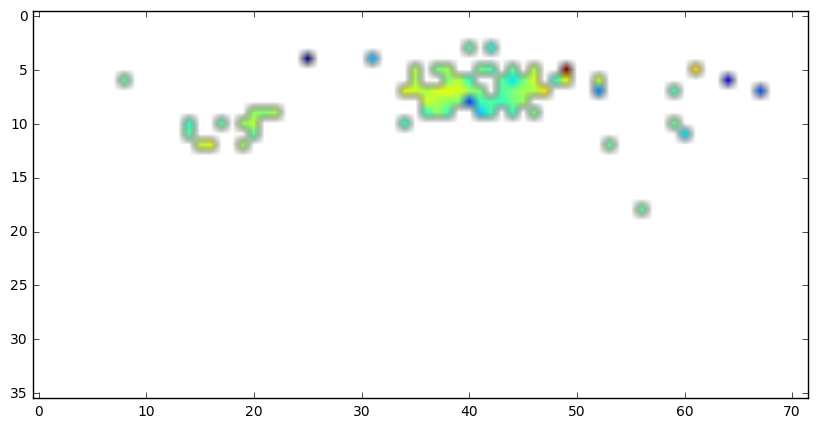

In [13]:
remote_path = 'ftp://ftp.cdc.noaa.gov/Datasets/cru/crutem4/std/'
last_file = 'air.mon.anom.nc'

local_path = os.getcwd()

print (remote_path)
print (last_file)
print (local_path)

with closing(urllib2.urlopen(remote_path+last_file)) as r:
    with open(last_file, 'wb') as f:
        shutil.copyfileobj(r, f)
        
# open a local NetCDF file
url = url=local_path+'/'+last_file
nc = netCDF4.Dataset(url)

# examine the variables
print nc.variables.keys()
print nc.variables['air']

# Selecting data
topo = nc.variables['air'][1,:,:]

# Ploting
plt.figure(figsize=(10,10))
plt.imshow(topo)

<br />
<span style="font-weight: bold; color:#444; font-family: 'Arial Narrow'; font-size: 2em;">Jones (CRU) Air and Marine Temperature Anomalies: HADCRUT4</span>
<br />
<span style="font-weight: bold; color:#444; font-family: 'Arial Narrow'; font-size: 2em;">https://www.esrl.noaa.gov/psd/data/gridded/data.hadcru4.html</span>

ftp://ftp.cdc.noaa.gov/Datasets/cru/hadcrut4/
air.mon.anom.median.nc
/Users/vizzuality/Documents/Vizzuality/RW/planet_pulse/Notebooks
[u'lat', u'lon', u'time', u'time_bnds', u'air']
<type 'netCDF4._netCDF4.Variable'>
float32 air(time, lat, lon)
    dataset: HADCRUT4
    var_desc: Air Temperature
    level_desc: Surface
    statistic: Anomaly
    parent_stat: Observation
    valid_range: [-40.  40.]
    units: degC
    missing_value: -9.96921e+36
    long_name: HADCRUT4: Median Surface Air Temperature Monthly Median Anomaly from 100 ensemble members
    precision: 2
    cell_methods: time: anomaly (monthly from values)
    standard_name: air_temperature_anomaly
    actual_range: [-20.84668732  20.62030792]
unlimited dimensions: time
current shape = (1975, 36, 72)
filling on, default _FillValue of 9.96920996839e+36 used



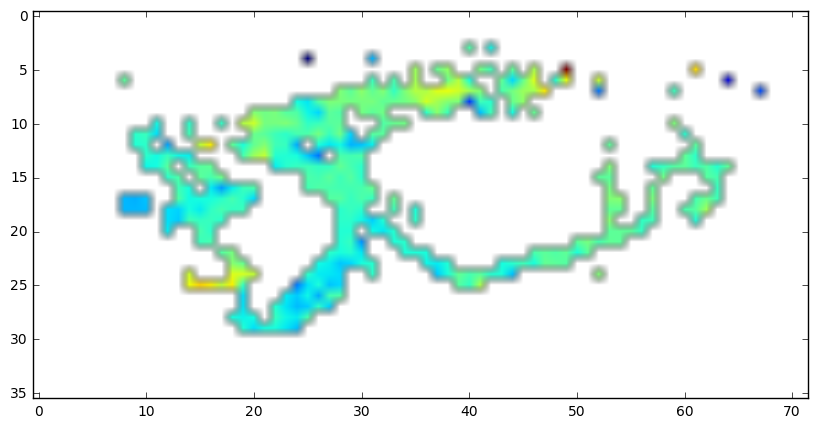

In [14]:
remote_path = 'ftp://ftp.cdc.noaa.gov/Datasets/cru/hadcrut4/'
last_file = 'air.mon.anom.median.nc'

local_path = os.getcwd()

print (remote_path)
print (last_file)
print (local_path)

with closing(urllib2.urlopen(remote_path+last_file)) as r:
    with open(last_file, 'wb') as f:
        shutil.copyfileobj(r, f)
        
# open a local NetCDF file
url = url=local_path+'/'+last_file
nc = netCDF4.Dataset(url)

# examine the variables
print nc.variables.keys()
print nc.variables['air']

# Data
topo = nc.variables['air'][1,:,:]

# Ploting
plt.figure(figsize=(10,10))
plt.imshow(topo)